# Activity target
## Librerias y parametros inciales

In [46]:
from importlib import reload
import lib.main_func_p1
import lib.main_func_p2
import lib.main_func_p3
import lib.main_func_p4
from lib.main_func_p1 import path

import pandas as pd
import numpy as np
# save the models
import pickle

In [47]:
#Escoger proteina (uniprot_ID) y el grupo al que pertenece
uniprot_id = 'P56817'
path_file = path(uniprot_id)

# Parametros
seed = 142854
fp_name = 'morgan2_c'

## Parte 1.Preprocesamiento de los datos


Declarar librerías y dependencias

In [48]:
reload(lib.main_func_p1)
from lib.main_func_p1 import get_info_target

In [49]:
try:
    with open(f'{path_file}_03_ligands_smiles_activity_type.csv') as f:
        print('Ya se cuenta con la información del target. No es necesario hacer este proceso')
        activity_df = pd.read_csv(f'{path_file}_03_ligands_smiles_activity_type.csv')
except FileNotFoundError:
    activity_df = get_info_target(uniprot_id)

Ya se cuenta con la información del target. No es necesario hacer este proceso


El dataset final solo tiene tres columnas: |molecule_chembl_id'| 'smiles'| 'activity_type'|
Se descartaron los compuestos que no cumplen la regla de los cinco.

In [50]:
activity_df.head()

,chembl_id_ligand,smiles,activity_type
0,CHEMBL4779999,Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1,Active
1,CHEMBL4741398,Brc1ccc(CNC2CCN(Cc3ccccc3)C2)cc1,Active
2,CHEMBL3640222,C#CCCOc1cnc(C(=O)Nc2cccc([C@]3(C)CCSC(N)=N3)c2...,Active
3,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,Active
4,CHEMBL562290,C#CCNC[C@@H](O)[C@H](Cc1ccccc1)NC(=O)c1cc2c3c(...,Active


In [51]:
# Comprobar que no hay smiles duplicados en el conjunto (debe dar false)
activity_df.duplicated(subset=['smiles']).value_counts()

False    6917
dtype: int64

## Parte 2. Análisis estadístico de los datos

Se declaran las librerias y dependencias
Se carga los data set para no volver a ejecutar la primera parte (tarda mucho tiempo la primera vez)

In [52]:
reload(lib.main_func_p2)
from lib.main_func_p2 import get_properties_stats, plot_radarplot

import matplotlib.pyplot as plt
import seaborn as sns

path_file = path(uniprot_id)
ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_ADME_lipinski.csv')
NO_ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_NO_ADME_lipinski.csv')
print('Archivo ADME_df / NO_ADME_df cargado')
activity_df = pd.read_csv(f'{path_file}_03_ligands_smiles_activity_type.csv')
print('Archivo SMILES + tipo_actividad cargado')

Archivo ADME_df / NO_ADME_df cargado
Archivo SMILES + tipo_actividad cargado


### Estadística ADME

#### All data

In [53]:
ADME_df_all = pd.concat([ADME_df, NO_ADME_df])
data_stats_full = get_properties_stats(ADME_df_all)
print('> Datos estadísticos de los compuestos filtrados por la regla de lipinski (todos los compuestos)')
data_stats_full

> Datos estadísticos de los compuestos filtrados por la regla de lipinski (todos los compuestos)


,mean,std
HBD,2.42,2.29
HBA,5.94,2.26
MW,469.23,141.95
LogP,3.46,1.56


> Resumen (gráfico) de las estadísticas (todos los compuestos)


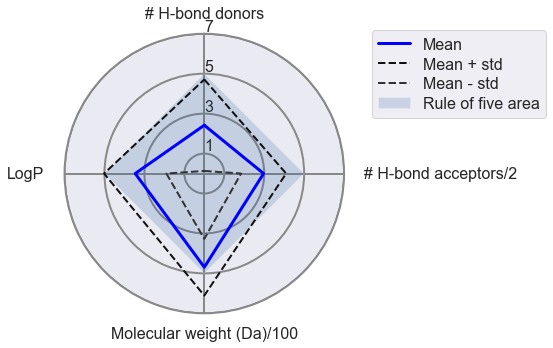

In [54]:
print('> Resumen (gráfico) de las estadísticas (todos los compuestos)')
plot_radarplot(uniprot_id, data_stats_full, 'IMG02_ADME_ALL')

#### Data filtered RoF: _no_

In [55]:
data_stats_NO = get_properties_stats(NO_ADME_df)
print('> Datos estadísticos de los compuestos filtrados por la regla de lipinski (no cumplen)')
data_stats_NO

> Datos estadísticos de los compuestos filtrados por la regla de lipinski (no cumplen)


,mean,std
HBD,5.55,5.12
HBA,8.15,4.47
MW,695.74,244.47
LogP,3.70,3.52


> Resumen (gráfico) de las estadísticas (no cumplen)


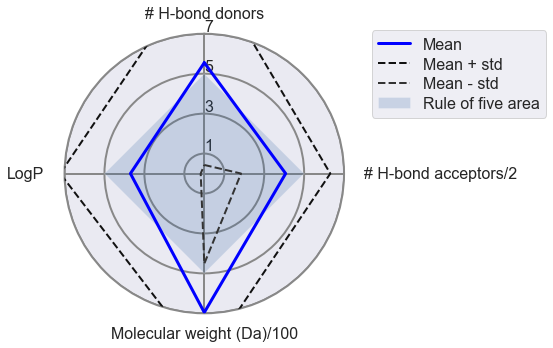

In [56]:
print('> Resumen (gráfico) de las estadísticas (no cumplen)')
plot_radarplot(uniprot_id, data_stats_NO, 'IMG02_ADME_NO')

#### Data filtered RoF: _yes_

In [57]:
data_stats = get_properties_stats(ADME_df)
print('> Datos estadísticos de los compuestos filtrados por la regla de lipinski (cumplen)')
data_stats

> Datos estadísticos de los compuestos filtrados por la regla de lipinski (cumplen)


,mean,std
HBD,2.01,1.03
HBA,5.66,1.56
MW,439.79,86.45
LogP,3.43,1.07


> Resumen (gráfico) de las estadísticas (cumplen)


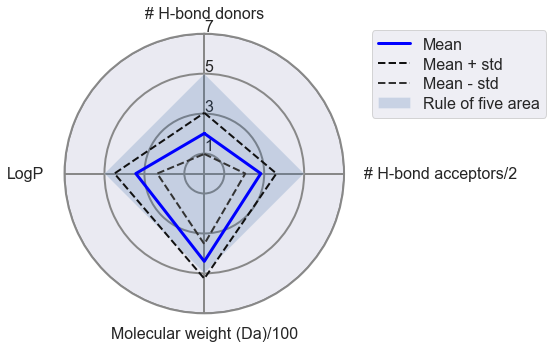

In [58]:
print('> Resumen (gráfico) de las estadísticas (cumplen)')
plot_radarplot(uniprot_id, data_stats, 'IMG02_ADME_YES')

### Estadísticas tipo de actividad

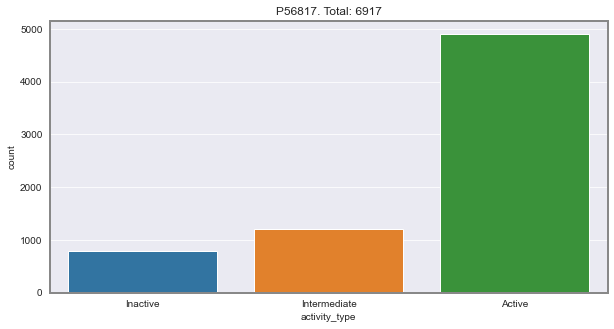

In [59]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax = sns.countplot(x='activity_type', data=ADME_df, order=['Inactive', 'Intermediate', 'Active'])
ax.set_title(f'{uniprot_id}. Total: {len(ADME_df)}')
plt.savefig(f'{path_file}_IMG01_activity_type.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Remove intermediate compounds

In [60]:
ADME_filtered_df = ADME_df[ADME_df['activity_type']!='Intermediate']
print(f'No. Active / inactive compounds: {len(ADME_filtered_df)}')

No. Active / inactive compounds: 5703


<Figure size 1440x1440 with 0 Axes>

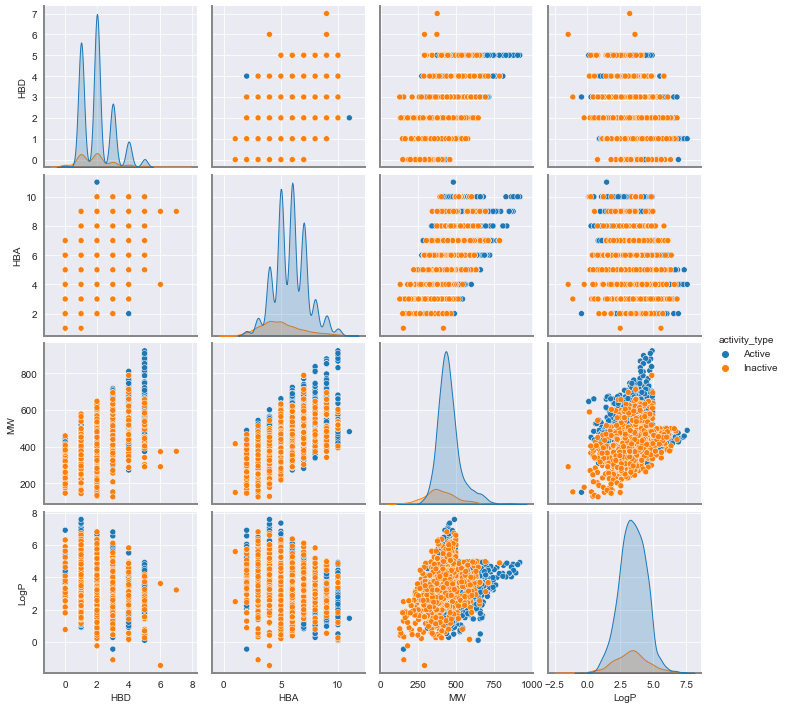

In [61]:
fig = plt.figure(figsize=(20, 20))
ax = sns.pairplot(data=ADME_filtered_df, vars=['HBD', 'HBA', 'MW', 'LogP'], hue='activity_type')
plt.savefig(f'{path_file}_IMG03_AllinOne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Parte 3. Carga de los fingerprint
Declarar librerias y dependencias
Carga de datasets para no volver a ejecutar la primera parte (tarda mucho tiempo la primera vez)

In [62]:
reload(lib.main_func_p3)
from lib.main_func_p3 import export_dataset

path_file = path(uniprot_id)
# Filtrado Activos / Inactivos
activity_filtered_df = pd.read_csv(f'{path_file}_03_ligands_smiles_activity_type.csv')
activity_filtered_df = activity_filtered_df[activity_df['activity_type'] != 'Intermediate']

A partir del SMILE se encuentra la representación vectorial de la fingerprint. Hay una gran variedad de fingerprints, la siguiente lista tiene algunas de las más comunes.
La lista completa está en `main_func_p3.py`

In [63]:
print("""
maccs                   MACCS KEys              nBits = 167
morgan2_c               ECFP4                   nBits = 1024
morgan3_c               ECFP6                   nBits = 1024
topological_torsions_b  TORSION                 nBits = 2048
rdkit5_b                RDK5                    nBits = 1024
avalon_512_b            AVALON                  nBits = 512
""")


maccs                   MACCS KEys              nBits = 167
morgan2_c               ECFP4                   nBits = 1024
morgan3_c               ECFP6                   nBits = 1024
topological_torsions_b  TORSION                 nBits = 2048
rdkit5_b                RDK5                    nBits = 1024
avalon_512_b            AVALON                  nBits = 512



Se decide trabajar con la fingerprint `morgan2_c`, la siguiente función encuentra la fingerprint de los compuestos del dataset y cambia la columna activity_type por activity, siendo 0: inactive y 1: active.
Para no volver a realizar todo el proceso anterior, se puede guardar el data set en formato pickle con la información de la fingerprint y la clasificación.

### Add fingerprint

La siguiente función encuentra las fingerprints seleccionadas (lista fp_list) de los compuestos del data set y cambia la columna activity_type por activity, siendo 0: inactive y 1: active.
Para no volver a realizar todo el proceso anterior, se puede guardar el data set en formato `pickle` con la información de las fingerprints y la clasificación

In [64]:
fp_list = [fp_name]
try:
    with open(f'{path_file}_dataset_full') as f:
        print('El archivo ya está en la base. No es necesario hacer este proceso')
        fp_df = pd.read_pickle(f'{path_file}_dataset_full')
except FileNotFoundError:
    # Construct a molecule from a SMILES string
    fp_df = export_dataset(activity_filtered_df, fp_list, verbose=False)
    fp_df.to_pickle(f'{path_file}_dataset_full')
    print(f'>>> SAVED: {path_file}_dataset_full, compounds: {len(fp_df)}')

El archivo ya está en la base. No es necesario hacer este proceso


### Train / test datasets

In [65]:
# Train a test set
test_size=0.15 #test_size: 15%
from sklearn.model_selection import train_test_split
fp_df_train, fp_df_test =  train_test_split(fp_df, test_size=test_size, shuffle=True, stratify=fp_df['activity'], random_state=seed)
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_test.reset_index(drop=True, inplace=True)
fp_df_train.to_pickle(f'{path_file}_dataset_train')
print(f'>>> SAVED: {path_file}_dataset_train, compounds: {len(fp_df_train)}')
fp_df_test.to_pickle(f'{path_file}_dataset_valid')
print(f'>>> SAVED: {path_file}_dataset_valid, compounds: {len(fp_df_test)}')

>>> SAVED: ./data/P56817/P56817_dataset_train, compounds: 4847
>>> SAVED: ./data/P56817/P56817_dataset_valid, compounds: 856


Este es un ejemplo del conjunto de entrenamiento guardado

In [66]:
fp_df_train.head()

,chembl_id_ligand,morgan2_c,activity
0,CHEMBL3898875,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,CHEMBL2347368,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,CHEMBL567485,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,CHEMBL2314782,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,CHEMBL4081377,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
